In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset
import csv
from PIL import Image
import re
#from torchsummary import summary

cudnn.benchmark = True
plt.ion()



d:\Uni_Sem3\DL\DL\dl-venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset

In [2]:
class CustomDataset(Dataset):
    def __init__(self, path, transform=None):
        super().__init__()
        self.transform = transform
        self.main_dir = os.path.join(path)
        self.all_imgs = sorted(os.listdir(self.main_dir), key=lambda s: int(re.search(r'\d+', s).group()))
        
    def __len__(self):
        return len(self.all_imgs)
    
    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

Device

In [3]:
#apple
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
#windows
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#torch.cuda.empty_cache()
print(device)

cuda:0


Load Data

In [4]:

data_transforms =  transforms.Compose([
        #transforms.Resize((512,512)),
        transforms.ToTensor(),
    ])
directory = os.getcwd()
data_dir = 'D:/Uni_Sem3/DL/DL/screw/train/good/'
train_dataset = CustomDataset(data_dir,data_transforms)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])
train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                             shuffle=False, num_workers=0)

val_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=4,
                                             shuffle=False, num_workers=0)

print(len(train_dataloader),len(val_dataloader))

64 16


View Data

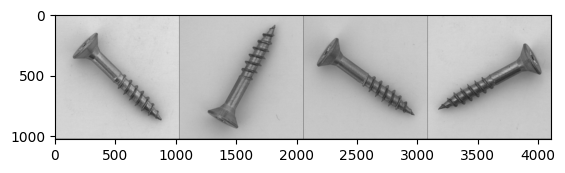

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of  data
inputs = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

Datasets & DataLoaders

In [6]:
image_datasets = {'train': train_dataset }
dataloaders = {'train': train_dataloader}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train']}


Encoder

In [7]:
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(256*29*29, 512),
            nn.ReLU(True),
        )    
        
        self.decoder = nn.Sequential(
            nn.Linear(512, 256*29*29),
            nn.ReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(256, 29, 29)),
            nn.ConvTranspose2d(256, 128, 4, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 4, 2, 1, bias=False),
            nn.ReLU(True)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        x = self.encoder(x)
        return x
    

In [8]:
testModel = AutoEncoder()
#summary(testModel, (3, 512, 512),4)


Model, Loss & Optimizer

In [9]:
torch.manual_seed(0)

loss = torch.nn.MSELoss()
lr= 0.0001

model = AutoEncoder()
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-05)

model.to(device)

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=

Train

In [10]:
def train_epoch(model, device, dataloader, loss_fn, optimizer):

    model.train()
    train_loss = []
    for image_batch in dataloader: 
        image_batch = image_batch.to(device)
        decoded_data = model(image_batch)
        loss = loss_fn(decoded_data, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

Validation Test

In [11]:
def test_epoch(model, device, dataloader, loss_fn):
    model.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch in dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model(image_batch)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

Plot Output

In [12]:
def plot_ae_outputs(model,n=10):
  inputs = next(iter(val_dataloader))
  out = torchvision.utils.make_grid(inputs)
  imshow(out)
  img = inputs.to(device)
  model.eval()
  with torch.no_grad():
      rec_img  = model(img)
  rec_img = rec_img.cpu()
  rec_out =  torchvision.utils.make_grid(rec_img)
  imshow(rec_out)

Training

In [13]:
num_epochs = 50
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(model,device,train_dataloader,loss,optim)
   val_loss = test_epoch(model,device,val_dataloader,loss)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(model,n=10)

OutOfMemoryError: CUDA out of memory. Tried to allocate 842.00 MiB (GPU 0; 4.00 GiB total capacity; 2.75 GiB already allocated; 0 bytes free; 2.85 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Plot Loss

In [ ]:
plt.plot(diz_loss['train_loss'],label='Training loss')
plt.plot(diz_loss['val_loss'],label='Validation loss')
plt.legend()
plt.show()


Temp Section do not delete

In [ ]:
inputs = next(iter(train_dataloader))
inputs = inputs.to(device)
out = model(inputs)
print(out.shape)
out = out.cpu()
out = torchvision.utils.make_grid(out)
out =  out.detach()
imshow(out)

In [ ]:
with torch.no_grad():
        conc_out = []
        for image_batch in val_dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model.encode(image_batch)
            conc_out.append(decoded_data.cpu())
        conc_out = torch.cat(conc_out)
print(conc_out)